# DF CON VARIABLES DE 4 HORAS #

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,root_mean_squared_error


In [ ]:
import requests
import pandas as pd
import time

def get_binance_ohlcv(symbol="BTCUSDT", interval="1h", days=1095):
    """
    Descarga velas OHLCV desde Binance.
    symbol: par de trading (ej: BTCUSDT)
    interval: intervalo de vela (ej: 1h, 1d, 15m)
    days: días de datos hacia atrás
    """
    base_url = "https://api.binance.com/api/v3/klines"
    
    # Binance limita 1000 velas por request → dividir en chunks
    limit = 1000
    ms_interval = 60 * 60 * 1000  # 1h en milisegundos
    if interval == "1d":
        ms_interval = 24 * 60 * 60 * 1000
    
    end_time = int(time.time() * 1000)  # ahora en ms
    start_time = end_time - days * 24 * 60 * 60 * 1000
    
    all_data = []
    
    while start_time < end_time:
        params = {
            "symbol": symbol,
            "interval": interval,
            "startTime": start_time,
            "limit": limit
        }
        resp = requests.get(base_url, params=params)
        data = resp.json()
        
        if not data:
            break
        
        all_data.extend(data)
        
        # avanzar el start_time al último timestamp + intervalo
        last_open_time = data[-1][0]
        start_time = last_open_time + ms_interval
        
        time.sleep(0.2)  # para no sobrecargar la API
    
    # convertir a DataFrame
    df = pd.DataFrame(all_data, columns=[
        "open_time", "open", "high", "low", "close", "volume",
        "close_time", "quote_asset_volume", "number_of_trades",
        "taker_buy_base", "taker_buy_quote", "ignore"
    ])
    
    # limpiar tipos de datos
    df["open_time"] = pd.to_datetime(df["open_time"], unit="ms")
    df["close_time"] = pd.to_datetime(df["close_time"], unit="ms")
    for col in ["open", "high", "low", "close", "volume"]:
        df[col] = df[col].astype(float)
    
    return df[["open_time", "open", "high", "low", "close", "volume"]]

df = get_binance_ohlcv("BTCUSDT", "1h", days=1095)

# guardar en CSV
df.to_csv("BTCUSDT_1h_3years.csv", index=False)


print(df.head())
print(df.tail())


            open_time      open      high       low     close       volume
0 2022-09-28 18:00:00  19345.55  19635.56  19281.00  19555.58  25085.35791
1 2022-09-28 19:00:00  19555.58  19659.20  19464.29  19546.72  21622.84307
2 2022-09-28 20:00:00  19546.72  19627.21  19491.87  19568.23  14430.07286
3 2022-09-28 21:00:00  19569.61  19790.00  19525.84  19618.44  10604.42236
4 2022-09-28 22:00:00  19618.79  19666.48  19411.58  19485.75  14428.39974
                open_time       open       high        low      close  \
26274 2025-09-27 13:00:00  109400.06  109412.14  109299.64  109306.61   
26275 2025-09-27 14:00:00  109306.61  109387.51  109255.90  109287.89   
26276 2025-09-27 15:00:00  109287.89  109427.40  109193.00  109402.24   
26277 2025-09-27 16:00:00  109402.25  109427.76  109308.00  109389.04   
26278 2025-09-27 17:00:00  109389.05  109395.22  109314.70  109314.70   

          volume  
26274  336.77227  
26275  273.62629  
26276  204.90854  
26277  176.55452  
26278    4.20860

In [3]:
df

,open_time,open,high,low,close,volume
0,2022-09-28 18:00:00,19345.55,19635.56,19281.00,19555.58,25085.35791
1,2022-09-28 19:00:00,19555.58,19659.20,19464.29,19546.72,21622.84307
2,2022-09-28 20:00:00,19546.72,19627.21,19491.87,19568.23,14430.07286
3,2022-09-28 21:00:00,19569.61,19790.00,19525.84,19618.44,10604.42236
4,2022-09-28 22:00:00,19618.79,19666.48,19411.58,19485.75,14428.39974
...,...,...,...,...,...,...
26274,2025-09-27 13:00:00,109400.06,109412.14,109299.64,109306.61,336.77227
26275,2025-09-27 14:00:00,109306.61,109387.51,109255.90,109287.89,273.62629
26276,2025-09-27 15:00:00,109287.89,109427.40,109193.00,109402.24,204.90854
26277,2025-09-27 16:00:00,109402.25,109427.76,109308.00,109389.04,176.55452


In [4]:
#df=pd.read_csv("/home/rodrigo/Escritorio/Repositorios/Proyecto_cripto_RH/src/BTCUSDT_1h_3years.csv")+

In [5]:
#vamos a ver como funciona sin el volumen
df_porcentual=pd.DataFrame(columns=["4hora%","dia%","2dias%","1semana%"])
def porcentaje (df,columna_objetivo,n_de_intervalos,columna_nueva):

    for i in range(n_de_intervalos,len(df[columna_objetivo])):
        cambio=(df[columna_objetivo][i-n_de_intervalos]-df[columna_objetivo][i])/df[columna_objetivo][i-n_de_intervalos]
        df.loc[i,columna_nueva]=cambio*100

porcentaje(df,"close",1,"1hora%")
porcentaje(df,"close",4,"4hora%")
porcentaje(df,"close",8,"8hora%")
porcentaje(df,"close",24,"dia%")
porcentaje(df,"close",48,"2dias%")
porcentaje(df,"close",24*7,"1semana%")
porcentaje(df,"close",24*7*2,"2semanas%")
porcentaje(df,"close",24*7*4,"1mes%")
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)

In [6]:
df_porcentual=df

In [7]:
df_porcentual["pred_dia%"]=df_porcentual["dia%"].shift(-24)

In [8]:

def calcular_RSI(df, column="close", period=14):
    """
    Calcula el RSI (Relative Strength Index) de un DataFrame.
    
    Parámetros:
        df: DataFrame con la columna de precios.
        column: columna sobre la cual calcular el RSI (por defecto 'close').
        period: ventana del RSI (por defecto 14).
        
    Retorna:
        DataFrame con una columna adicional 'RSI'.
    """
    # Calcular diferencias entre cierres
    delta = df[column].diff()

    # Separar ganancias y pérdidas
    ganancias = delta.clip(lower=0)
    perdidas = -delta.clip(upper=0)

    # Calcular medias móviles exponenciales
    media_gan = ganancias.ewm(span=period, adjust=False).mean()
    media_per = perdidas.ewm(span=period, adjust=False).mean()

    # Calcular RS y RSI
    RS = media_gan / media_per
    RSI = 100 - (100 / (1 + RS))

    df["RSI"] = RSI
    return df
calcular_RSI(df_porcentual)

,open_time,open,high,low,close,volume,1hora%,4hora%,8hora%,dia%,2dias%,1semana%,2semanas%,1mes%,pred_dia%,RSI
0,2022-10-26 18:00:00,20822.60,20869.18,20657.23,20696.83,14447.22609,0.609353,0.655915,-0.138910,-2.086585,-7.045279,-7.872849,-8.260438,-5.835930,0.547089,NaN
1,2022-10-26 19:00:00,20696.83,20789.34,20639.98,20763.54,11713.53448,-0.322320,0.398721,-0.755684,-2.418964,-7.342672,-7.960186,-8.498431,-6.225188,0.645121,100.000000
2,2022-10-26 20:00:00,20764.52,20852.94,20694.28,20743.92,13662.68226,0.094493,0.088622,-0.950576,-2.748676,-7.045890,-8.071026,-8.201524,-6.008157,1.678178,95.671120
3,2022-10-26 21:00:00,20745.13,20761.99,20701.14,20739.38,4366.25913,0.021886,0.405019,-0.908348,-2.506289,-7.089385,-8.049287,-8.128492,-5.713706,1.600482,94.577993
4,2022-10-26 22:00:00,20739.38,20905.05,20700.00,20817.07,11811.86326,-0.374601,-0.580959,0.078767,-3.756959,-7.519912,-8.759962,-8.674852,-6.832275,2.630053,95.576053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25602,2025-09-27 13:00:00,109400.06,109412.14,109299.64,109306.61,336.77227,0.085411,-0.012700,0.300185,0.331103,1.525577,5.701716,5.575658,-0.714514,NaN,43.389970
25603,2025-09-27 14:00:00,109306.61,109387.51,109255.90,109287.89,273.62629,0.017126,0.131415,0.231392,-0.415203,2.019105,5.762222,5.621693,-0.576006,NaN,42.383793
25604,2025-09-27 15:00:00,109287.89,109427.40,109193.00,109402.24,204.90854,-0.104632,-0.084192,0.008189,-0.343454,1.952424,5.676901,5.499277,-0.488895,NaN,50.477794
25605,2025-09-27 16:00:00,109402.25,109427.76,109308.00,109389.04,176.55452,0.012066,0.010064,-0.125426,0.064836,1.413382,5.721811,5.154560,-0.526872,NaN,49.550636


In [9]:
def agregar_emas(df, column="close", spans=[9, 21, 50, 100,200]):

    for span in spans:
        df[f"EMA_{span}"] = df[column].ewm(span=span, adjust=False).mean()
    return df
agregar_emas(df_porcentual)

,open_time,open,high,low,close,volume,1hora%,4hora%,8hora%,dia%,...,1semana%,2semanas%,1mes%,pred_dia%,RSI,EMA_9,EMA_21,EMA_50,EMA_100,EMA_200
0,2022-10-26 18:00:00,20822.60,20869.18,20657.23,20696.83,14447.22609,0.609353,0.655915,-0.138910,-2.086585,...,-7.872849,-8.260438,-5.835930,0.547089,NaN,20696.830000,20696.830000,20696.830000,20696.830000,20696.830000
1,2022-10-26 19:00:00,20696.83,20789.34,20639.98,20763.54,11713.53448,-0.322320,0.398721,-0.755684,-2.418964,...,-7.960186,-8.498431,-6.225188,0.645121,100.000000,20710.172000,20702.894545,20699.446078,20698.150990,20697.493781
2,2022-10-26 20:00:00,20764.52,20852.94,20694.28,20743.92,13662.68226,0.094493,0.088622,-0.950576,-2.748676,...,-8.071026,-8.201524,-6.008157,1.678178,95.671120,20716.921600,20706.624132,20701.190154,20699.057307,20697.955734
3,2022-10-26 21:00:00,20745.13,20761.99,20701.14,20739.38,4366.25913,0.021886,0.405019,-0.908348,-2.506289,...,-8.049287,-8.128492,-5.713706,1.600482,94.577993,20721.413280,20709.601938,20702.687795,20699.855776,20698.367915
4,2022-10-26 22:00:00,20739.38,20905.05,20700.00,20817.07,11811.86326,-0.374601,-0.580959,0.078767,-3.756959,...,-8.759962,-8.674852,-6.832275,2.630053,95.576053,20740.544624,20719.371762,20707.173371,20702.176850,20699.549031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25602,2025-09-27 13:00:00,109400.06,109412.14,109299.64,109306.61,336.77227,0.085411,-0.012700,0.300185,0.331103,...,5.701716,5.575658,-0.714514,NaN,43.389970,109385.815283,109451.508064,109907.629180,110885.914233,112217.737949
25603,2025-09-27 14:00:00,109306.61,109387.51,109255.90,109287.89,273.62629,0.017126,0.131415,0.231392,-0.415203,...,5.762222,5.621693,-0.576006,NaN,42.383793,109366.230227,109436.633694,109883.325682,110854.270189,112188.585233
25604,2025-09-27 15:00:00,109287.89,109427.40,109193.00,109402.24,204.90854,-0.104632,-0.084192,0.008189,-0.343454,...,5.676901,5.499277,-0.488895,NaN,50.477794,109373.432181,109433.506995,109864.459577,110825.517116,112160.860405
25605,2025-09-27 16:00:00,109402.25,109427.76,109308.00,109389.04,176.55452,0.012066,0.010064,-0.125426,0.064836,...,5.721811,5.154560,-0.526872,NaN,49.550636,109376.553745,109429.464541,109845.815672,110797.072024,112133.280103


In [10]:
df_porcentual

,open_time,open,high,low,close,volume,1hora%,4hora%,8hora%,dia%,...,1semana%,2semanas%,1mes%,pred_dia%,RSI,EMA_9,EMA_21,EMA_50,EMA_100,EMA_200
0,2022-10-26 18:00:00,20822.60,20869.18,20657.23,20696.83,14447.22609,0.609353,0.655915,-0.138910,-2.086585,...,-7.872849,-8.260438,-5.835930,0.547089,NaN,20696.830000,20696.830000,20696.830000,20696.830000,20696.830000
1,2022-10-26 19:00:00,20696.83,20789.34,20639.98,20763.54,11713.53448,-0.322320,0.398721,-0.755684,-2.418964,...,-7.960186,-8.498431,-6.225188,0.645121,100.000000,20710.172000,20702.894545,20699.446078,20698.150990,20697.493781
2,2022-10-26 20:00:00,20764.52,20852.94,20694.28,20743.92,13662.68226,0.094493,0.088622,-0.950576,-2.748676,...,-8.071026,-8.201524,-6.008157,1.678178,95.671120,20716.921600,20706.624132,20701.190154,20699.057307,20697.955734
3,2022-10-26 21:00:00,20745.13,20761.99,20701.14,20739.38,4366.25913,0.021886,0.405019,-0.908348,-2.506289,...,-8.049287,-8.128492,-5.713706,1.600482,94.577993,20721.413280,20709.601938,20702.687795,20699.855776,20698.367915
4,2022-10-26 22:00:00,20739.38,20905.05,20700.00,20817.07,11811.86326,-0.374601,-0.580959,0.078767,-3.756959,...,-8.759962,-8.674852,-6.832275,2.630053,95.576053,20740.544624,20719.371762,20707.173371,20702.176850,20699.549031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25602,2025-09-27 13:00:00,109400.06,109412.14,109299.64,109306.61,336.77227,0.085411,-0.012700,0.300185,0.331103,...,5.701716,5.575658,-0.714514,NaN,43.389970,109385.815283,109451.508064,109907.629180,110885.914233,112217.737949
25603,2025-09-27 14:00:00,109306.61,109387.51,109255.90,109287.89,273.62629,0.017126,0.131415,0.231392,-0.415203,...,5.762222,5.621693,-0.576006,NaN,42.383793,109366.230227,109436.633694,109883.325682,110854.270189,112188.585233
25604,2025-09-27 15:00:00,109287.89,109427.40,109193.00,109402.24,204.90854,-0.104632,-0.084192,0.008189,-0.343454,...,5.676901,5.499277,-0.488895,NaN,50.477794,109373.432181,109433.506995,109864.459577,110825.517116,112160.860405
25605,2025-09-27 16:00:00,109402.25,109427.76,109308.00,109389.04,176.55452,0.012066,0.010064,-0.125426,0.064836,...,5.721811,5.154560,-0.526872,NaN,49.550636,109376.553745,109429.464541,109845.815672,110797.072024,112133.280103


In [11]:
def volumen_por_precio(df, price_col="close", volume_col="volume", bins=100):
    """
    Calcula volumen por nivel de precio (Volume Profile).
    
    Parámetros:
        df: DataFrame con precios y volúmenes.
        price_col: columna de precios (por defecto 'close').
        volume_col: columna de volúmenes (por defecto 'volume').
        bins: número de intervalos de precio.
    
    Retorna:
        DataFrame con niveles de precio y volumen acumulado.
    """
    precios = df[price_col]
    volumenes = df[volume_col]

    # Crear bins de precio
    hist, edges = np.histogram(precios, bins=bins, weights=volumenes)

    # Calcular punto medio de cada bin
    price_levels = (edges[:-1] + edges[1:]) / 2

    vp = pd.DataFrame({"price_level": price_levels, "volume": hist})
    vp = vp.sort_values(by="volume", ascending=False).reset_index(drop=True)
    return vp
resistencias=volumen_por_precio(df_porcentual)

In [12]:
resistencias

,price_level,volume
0,17272.49465,8.134736e+06
1,22682.41015,6.201472e+06
2,20518.44395,5.690885e+06
3,16190.51155,5.191254e+06
4,23764.39325,4.801953e+06
...,...,...
95,120060.88915,4.143653e+04
96,122224.85535,2.819672e+04
97,121142.87225,1.982579e+04
98,123306.83845,6.901755e+03


In [13]:
#agregamos precios de resistencias
#vamos a poner 1 en cada zona de resistencia y 0 en donde no hay resistencias de volumen 
resis=[]
df_porcentual["resistencia"]=0
lista_redondeada_high = [round(x, 0) for x in list(df_porcentual["high"])]
lista_redondeada_low = [round(x, 0) for x in list(df_porcentual["low"])]
lista_redondeada_close = [round(x, 0) for x in list(df_porcentual["close"])]
for i in list(round(resistencias["price_level"],0)):
    if i in lista_redondeada_high:

        indice=lista_redondeada_high.index(i)
        df_porcentual.loc[indice,"resistencia"]=1
    elif i in lista_redondeada_low:

        indice=lista_redondeada_low.index(i)
        df_porcentual.loc[indice,"resistencia"]=1
    elif i in lista_redondeada_close:

        indice=lista_redondeada_close.index(i)
        df_porcentual.loc[indice,"resistencia"]=1

In [14]:
df_porcentual.dropna(inplace=True)
df_porcentual.reset_index(drop=True,inplace=True)

In [15]:
#vamos a asignar un valor a cada valor de volumen localizado


In [16]:
#zonas de bajo volumen, mayor movimiento


In [17]:
df_porcentual

,open_time,open,high,low,close,volume,1hora%,4hora%,8hora%,dia%,...,2semanas%,1mes%,pred_dia%,RSI,EMA_9,EMA_21,EMA_50,EMA_100,EMA_200,resistencia
0,2022-10-26 19:00:00,20696.83,20789.34,20639.98,20763.54,11713.53448,-0.322320,0.398721,-0.755684,-2.418964,...,-8.498431,-6.225188,0.645121,100.000000,20710.172000,20702.894545,20699.446078,20698.150990,20697.493781,0
1,2022-10-26 20:00:00,20764.52,20852.94,20694.28,20743.92,13662.68226,0.094493,0.088622,-0.950576,-2.748676,...,-8.201524,-6.008157,1.678178,95.671120,20716.921600,20706.624132,20701.190154,20699.057307,20697.955734,0
2,2022-10-26 21:00:00,20745.13,20761.99,20701.14,20739.38,4366.25913,0.021886,0.405019,-0.908348,-2.506289,...,-8.128492,-5.713706,1.600482,94.577993,20721.413280,20709.601938,20702.687795,20699.855776,20698.367915,0
3,2022-10-26 22:00:00,20739.38,20905.05,20700.00,20817.07,11811.86326,-0.374601,-0.580959,0.078767,-3.756959,...,-8.674852,-6.832275,2.630053,95.576053,20740.544624,20719.371762,20707.173371,20702.176850,20699.549031,0
4,2022-10-26 23:00:00,20816.75,20907.00,20737.19,20771.59,9008.88520,0.218475,-0.038770,0.360106,-3.443813,...,-8.436519,-6.999344,2.293902,85.006601,20746.753699,20724.118875,20709.699514,20703.551368,20700.265856,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25577,2025-09-26 13:00:00,109372.68,109779.73,109000.00,109669.73,991.99403,-0.271594,-0.092189,-0.381629,1.198441,...,4.772848,-0.516552,0.331103,55.303629,109402.337307,109715.773600,110674.723053,111781.226854,112973.237981,0
25578,2025-09-26 14:00:00,109669.72,109779.73,108764.76,108836.00,900.45250,0.760219,0.054181,0.479151,2.424242,...,5.573486,-0.589037,-0.415203,36.990065,109289.069846,109635.794182,110602.616266,111722.905531,112932.071434,0
25579,2025-09-26 15:00:00,108836.00,109358.50,108802.04,109027.78,486.11543,-0.176210,0.096872,0.267325,2.288020,...,5.293031,-0.591911,-0.343454,42.080661,109236.811877,109580.520165,110540.857981,111669.536708,112893.222763,0
25580,2025-09-26 16:00:00,109027.79,109618.00,109027.78,109460.01,291.37899,-0.396440,-0.079846,0.097830,1.349420,...,5.225785,-0.693929,0.064836,52.136600,109281.451501,109569.564696,110498.471786,111625.783704,112859.061442,0


In [31]:
relativ_error=[]
aciertos_direccion_list=[]
error_aciertos_list=[]
y_pred_guardadas=[]
y_real_guardadas=[]
restricciones=["open_time","pred_dia%"]
medir="pred_dia%"
for i in range(81):
    print(i)
    #vamos a separar los datos de entreno y los outsider
    entreno=df_porcentual[15100+i:20100+i]
    outsider=df_porcentual[20100+i+1:20100+i+2]
    #print(outsider)
    outsider.reset_index(drop=True,inplace=True)
    entreno.reset_index(drop=True,inplace=True)
    #ahora ponemos el y el x
    X_entreno=entreno.drop(restricciones,axis=1)
    y=entreno[medir]
    X_train, X_test, y_train, y_test = train_test_split(X_entreno, y, test_size=0.001, random_state=42)
    model=RandomForestRegressor( n_estimators=50, random_state=42)
    model.fit(X_train,y_train)
    X_outsider=outsider.drop(restricciones,axis=1)
    y_outsider=outsider[medir]#es el real
    predicciones_outsider=model.predict(X_outsider)
    #print(y_outsider[0])
    y_pred_guardadas.append(predicciones_outsider[0])
    y_real_guardadas.append(y_outsider[0])
    error_relativo_porcentual=abs(y_outsider[0]-predicciones_outsider)/y_outsider[0]
    relativ_error.append(error_relativo_porcentual)
    if y_outsider[0]*predicciones_outsider>0:
        aciertos_direccion_list.append(predicciones_outsider)
        error_relativo_aciertos=abs(y_outsider[0]-predicciones_outsider)/y_outsider[0]
        error_aciertos_list.append(error_relativo_aciertos)

error_total=abs(np.array(relativ_error).sum())/len(relativ_error)
aciertos_direccion=len(aciertos_direccion_list)
error_aciertos=abs(np.array(error_aciertos_list).sum())/len(error_aciertos_list)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80


In [32]:
tabla_resultados=pd.DataFrame(columns=["error_total","error_aciertos","aciertos_direccion"])
tabla_resultados["error_total"]=error_total
tabla_resultados["error_aciertos"]=error_aciertos
tabla_resultados["aciertos_direccion"]=aciertos_direccion
print(f'error_aciertos: {error_aciertos}')
print(f'n_aciertos: {aciertos_direccion/len(relativ_error)}')
print(f'error total: {error_total}')

error_aciertos: 12.784665317862432
n_aciertos: 0.8518518518518519
error total: 10.99420671689738


<Axes: xlabel='None', ylabel='real'>

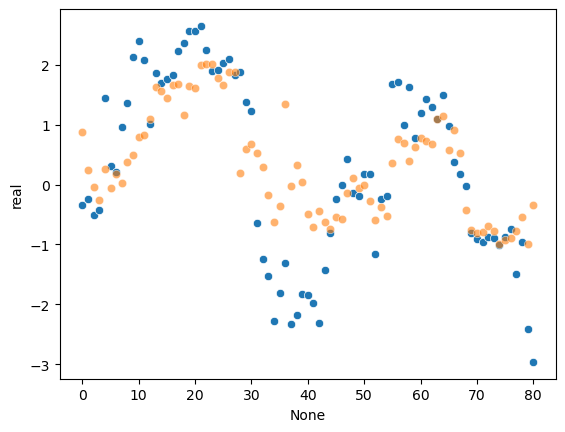

In [33]:
guardados=pd.DataFrame(columns=["real","predicciones","dif"])
guardados["real"]=y_real_guardadas
guardados["predicciones"]=y_pred_guardadas
sns.scatterplot(guardados,x=guardados.index,y=guardados["real"])
sns.scatterplot(guardados,x=guardados.index,y="predicciones",alpha=0.6)

In [21]:
guardados

,real,predicciones,dif
0,-0.292470,-0.270345,NaN
1,-0.809411,-0.676456,NaN
2,-1.257404,-1.434527,NaN
3,-0.968364,-0.382658,NaN
4,-1.261013,0.008093,NaN
...,...,...,...
76,0.407538,-0.748462,NaN
77,0.873013,-0.115327,NaN
78,1.412119,0.073977,NaN
79,1.310845,0.452924,NaN


In [22]:
#hay que traducir a precio
#predio anterior-precio nuevo/precio anterior
#%*precioanterior--precioanterior
precios=[]
comparacion=pd.DataFrame(columns=["real","prediccion"])
rev=df_porcentual["close"].tail(len(guardados["predicciones"]))
rev.dropna(inplace=True)
rev.reset_index(drop=True,inplace=True)
for i in range(len(guardados["predicciones"])):
    precio=(rev[i])-((abs(guardados["predicciones"][i])/100)*(rev[i]))
    print(precio)
    precios.append(precio)
comparacion["real"]=rev
comparacion["prediccion"]=precios


112629.15688568338
112205.1317916398
111355.3193222085
112508.8421001597
112943.168909627
112603.82208478858
112296.76846192851
112370.97612734533
110993.05087223761
110824.04196494607
111394.93390829612
111933.90365629221
111648.07410127985
110943.82133563956
110795.18210838501
111322.87201232661
111581.91747661984
111332.20731750735
111065.25447244928
111512.5536455772
112606.27816639097
112271.68619100633
112234.27181852951
112260.47557111835
112429.20001578596
112286.59345449515
112299.3174592874
112470.89431819078
111610.47548120514
112215.4297014609
111879.50252482384
111612.99582837812
112058.92166541918
111926.7273185787
112294.96425068477
112095.97920408226
111683.3335963769
112045.89062028416
112653.37595083212
112579.30354307765
112472.06052413468
112463.75650637895
112106.64776631593
111436.82256685302
111568.83312806286
111107.54789594717
110720.98377297347
111218.22596765745
110442.74510255542
110385.85514723246
110271.93743415846
110017.82936210334
110012.66838091098
109

In [23]:
comparacion

,real,prediccion
0,112934.47,112629.156886
1,112969.32,112205.131792
2,112975.99,111355.319322
3,112941.02,112508.842100
4,112952.31,112943.168910
...,...,...
76,109669.73,108848.893271
77,108836.00,108710.482932
78,109027.78,108947.124992
79,109460.01,108964.239116


# XGBoots #

In [24]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [25]:

relativ_error=[]
aciertos_direccion_list=[]
error_aciertos_list=[]
y_pred_guardadas=[]
y_real_guardadas=[]
restricciones=["open_time","pred_dia%"]
medir="pred_dia%"
for i in range(100):
    print(i)
    #vamos a separar los datos de entreno y los outsider
    entreno=df_porcentual[15000+i:20800+i]
    outsider=df_porcentual[20800+i+1:20800+i+2]
    #print(outsider)
    outsider.reset_index(drop=True,inplace=True)
    entreno.reset_index(drop=True,inplace=True)
    #ahora ponemos el y el x
    X_entreno=entreno.drop(restricciones,axis=1)
    y=entreno[medir]
    X_train, X_test, y_train, y_test = train_test_split(X_entreno, y, test_size=0.001, random_state=42)
    model=XGBRegressor(random_state=42,colsample_bytree=1.0, gamma= 0.5, learning_rate= 0.04 ,min_child_weight= 5, n_estimators= 500, reg_alpha= 0.01, reg_lambda= 0.5, subsample= 0.8)
    model.fit(X_train,y_train)
    X_outsider=outsider.drop(restricciones,axis=1)
    y_outsider=outsider[medir]#es el real
    predicciones_outsider=model.predict(X_outsider)
    #print(y_outsider[0])
    y_pred_guardadas.append(predicciones_outsider[0])
    y_real_guardadas.append(y_outsider[0])
    error_relativo_porcentual=abs(y_outsider[0]-predicciones_outsider)/y_outsider[0]
    relativ_error.append(error_relativo_porcentual)
    if y_outsider[0]*predicciones_outsider>0:
        aciertos_direccion_list.append(predicciones_outsider)
        error_relativo_aciertos=abs(y_outsider[0]-predicciones_outsider)/y_outsider[0]
        error_aciertos_list.append(error_relativo_aciertos)

error_total=abs(np.array(relativ_error).sum())/len(relativ_error)
aciertos_direccion=len(aciertos_direccion_list)
error_aciertos=abs(np.array(error_aciertos_list).sum())/len(error_aciertos_list)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [26]:
tabla_resultados=pd.DataFrame(columns=["error_total","error_aciertos","aciertos_direccion"])
tabla_resultados["error_total"]=error_total
tabla_resultados["error_aciertos"]=error_aciertos
tabla_resultados["aciertos_direccion"]=aciertos_direccion
print(f'error_aciertos: {error_aciertos}')
print(f'n_aciertos: {aciertos_direccion/len(relativ_error)}')
print(f'error total: {error_total}')


error_aciertos: 0.38208554070817163
n_aciertos: 0.71
error total: 0.8095216531904671


<Axes: xlabel='None', ylabel='real'>

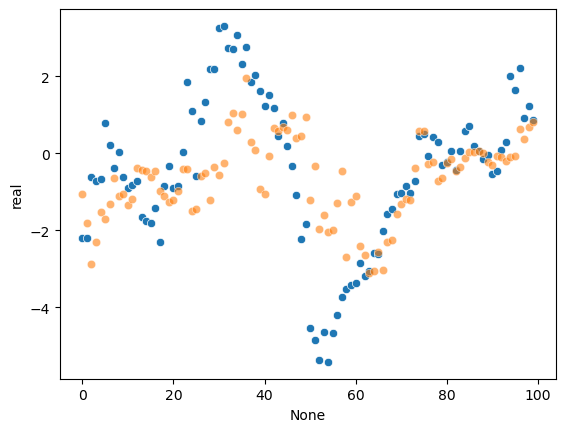

In [27]:
guardados=pd.DataFrame(columns=["real","predicciones","dif"])
guardados["real"]=y_real_guardadas
guardados["predicciones"]=y_pred_guardadas
sns.scatterplot(guardados,x=guardados.index,y=guardados["real"])
sns.scatterplot(guardados,x=guardados.index,y="predicciones",alpha=0.6)

In [28]:
def detectar_zonas_bajo_volumen(df, bins=80, n_zonas=150):
    """
    Calcula las zonas de bajo volumen (LVN) a partir de un perfil de volumen simple.

    bins: número de niveles de precios en el histograma
    n_zonas: cantidad de zonas de bajo volumen que quieres identificar
    """
    # Tomamos precio medio de cada vela
    df["precio_medio"] = (df["high"] + df["low"]) / 2
    precios = df["precio_medio"]
    volumenes = df["volume"]

    # Construir histograma ponderado por volumen
    hist, edges = np.histogram(precios, bins=bins, weights=volumenes)

    # Normalizamos
    hist = hist / hist.max()

    # Detectar los índices de menor volumen
    indices_lv = np.argsort(hist)[:n_zonas]
    zonas_bajo_volumen = [(edges[i], edges[i+1], hist[i]) for i in indices_lv]
   
    return zonas_bajo_volumen, hist, edges
zbv=detectar_zonas_bajo_volumen(df_porcentual)


In [29]:
#zonas de bajo volumen
df_porcentual["bajo_volumen"]=0
for i in zbv[0]:
    down=list(df_porcentual["close"].round(-3)).index(round(float(i[0]),-3))
    up=list(df_porcentual["close"].round(-3)).index(round(float(i[1]),-3))
    for o in range(1000):
        if df_porcentual["close"][o]==o:
            break
        elif df_porcentual["close"][o]!=o:
            df_porcentual.loc[o,"bajo_volumen"]=1

            






In [30]:
#agregar las zonas de bajo volumen
for i in zbv[0]:
    for o in i:
        print(o)

122510.464625
123862.95
0.0011622287707119192
31893.944499999998
33246.429875
0.002680333018541581
121157.97924999999
122510.464625
0.0030933974698448795
119805.493875
121157.97924999999
0.004393186043904317
76525.961875
77878.44725
0.007116211452677171
73820.991125
75173.4765
0.007509938767265073
49476.254375000004
50828.73974999999
0.007753049300728211
48123.769
49476.254375000004
0.007985578362468092
77878.44725
79230.932625
0.008633290138246388
72468.50575
73820.991125
0.009739660495129912
113043.067
114395.552375
0.01087539515555622
75173.4765
76525.961875
0.01179823191758146
80583.41799999999
81935.903375
0.013152582314774449
52181.225125
53533.7105
0.01330849603132304
111690.58162499999
113043.067
0.013864454834059797
118453.0085
119805.493875
0.014040884851632773
110338.09624999999
111690.58162499999
0.014141770896905886
115748.03774999999
117100.52312499999
0.01531437451615975
114395.552375
115748.03774999999
0.015323641332676817
53533.7105
54886.195875000005
0.016079364255521

In [37]:
import requests

url = "https://api.binance.com/api/v3/exchangeInfo"
data = requests.get(url).json()

# Extraer todos los símbolos disponibles
symbols = [s['symbol'] for s in data['symbols']]
print(symbols[:20])  # mostrar los primeros 20

['ETHBTC', 'LTCBTC', 'BNBBTC', 'NEOBTC', 'QTUMETH', 'EOSETH', 'SNTETH', 'BNTETH', 'BCCBTC', 'GASBTC', 'BNBETH', 'BTCUSDT', 'ETHUSDT', 'HSRBTC', 'OAXETH', 'DNTETH', 'MCOETH', 'ICNETH', 'MCOBTC', 'WTCBTC']
